<a href="https://colab.research.google.com/github/firahdw/popoyorepo/blob/main/DAC0023_PejuangDeadline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install pandas scikit-learn matplotlib seaborn

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import zipfile
import os

In [13]:
# Upload and extract the dataset.zip file
from google.colab import files
uploaded = files.upload()

# Extract the uploaded zip file
zip_file_path = list(uploaded.keys())[0]
extracted_folder_path = '/content/dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# List the extracted files
os.listdir(extracted_folder_path)

Saving dataset.zip to dataset.zip


['dataset']

In [14]:
# Load the main datasets: train.csv, test.csv, and Weather.csv
train_data = pd.read_csv(os.path.join(extracted_folder_path, 'dataset', 'train.csv'))
weather_data = pd.read_csv(os.path.join(extracted_folder_path, 'dataset', 'Weather.csv'))
test_data = pd.read_csv(os.path.join(extracted_folder_path, 'dataset', 'test.csv'))

In [15]:
# Check the first few rows of the train and weather data
print(train_data.head())
print(weather_data.head())

# Check for missing values
print("Missing values in train_data:\n", train_data.isnull().sum())
print("Missing values in weather_data:\n", weather_data.isnull().sum())

          Timestamp  % Baseline
0   Jan 1, 2014 7am      0.0079
1   Jan 1, 2014 8am      0.1019
2   Jan 1, 2014 9am      0.3932
3  Jan 1, 2014 10am      0.5447
4  Jan 1, 2014 11am      0.5485
       date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0  1/1/2014 0:00        -3        -6           0.0      8.7        2   
1  1/1/2014 1:00        -3        -6           0.0      8.7        2   
2  1/1/2014 2:00        -3        -6           0.0      8.7        2   
3  1/1/2014 3:00        -3        -6           0.0      8.7        2   
4  1/1/2014 4:00        -3        -6           0.0      8.7        2   

   moon_illumination moonrise  moonset  sunrise  ... WindChillC  WindGustKmph  \
0                  1  6:58 AM  5:05 PM  7:12 AM  ...        -11            28   
1                  1  6:58 AM  5:05 PM  7:12 AM  ...        -12            31   
2                  1  6:58 AM  5:05 PM  7:12 AM  ...        -12            34   
3                  1  6:58 AM  5:05 PM  7:12 AM  ..

In [16]:
# Load the main datasets: train.csv, test.csv, and Weather.csv
train_data = pd.read_csv(os.path.join(extracted_folder_path, 'dataset', 'train.csv'))
weather_data = pd.read_csv(os.path.join(extracted_folder_path, 'dataset', 'Weather.csv'))
test_data = pd.read_csv(os.path.join(extracted_folder_path, 'dataset', 'test.csv'))

# Correct the Timestamp conversion by specifying the format
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%b %d, %Y %I%p')
weather_data['date_time'] = pd.to_datetime(weather_data['date_time'], format='%m/%d/%Y %H:%M')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%b %d, %Y %I%p')

# Merge the training data with the weather data on the nearest timestamp
merged_train = pd.merge_asof(train_data.sort_values('Timestamp'), weather_data.sort_values('date_time'),
                            left_on='Timestamp', right_on='date_time')

# Drop unnecessary columns
merged_train.drop(columns=['date_time', 'moonrise', 'moonset', 'sunrise', 'sunset', 'moon_illumination'], inplace=True)

In [17]:
# Review basic statistics (mean, median, standard deviation) of numerical features
summary_stats = merged_train.describe()

# Identify any missing values and their distribution
missing_values = merged_train.isnull().sum()

print("Summary Statistics:")
print(summary_stats)
print("\nMissing Values:")
print(missing_values)

Summary Statistics:
                           Timestamp    % Baseline      maxtempC  \
count                          18942  18942.000000  18942.000000   
mean   2015-11-18 10:33:35.140956416      0.242342     15.267976   
min              2014-01-01 07:00:00      0.000000    -12.000000   
25%              2014-11-24 08:15:00      0.031800      8.000000   
50%              2015-11-15 07:30:00      0.134700     16.000000   
75%              2016-10-08 17:45:00      0.407700     24.000000   
max              2017-09-30 18:00:00      1.016900     32.000000   
std                              NaN      0.256525      9.434761   

           mintempC  totalSnow_cm       sunHour       uvIndex     DewPointC  \
count  18942.000000  18942.000000  18942.000000  18942.000000  18942.000000   
mean       8.814539      0.107745     10.669069      3.850966      7.765759   
min      -20.000000      0.000000      3.400000      1.000000    -22.000000   
25%        3.000000      0.000000      8.700000    

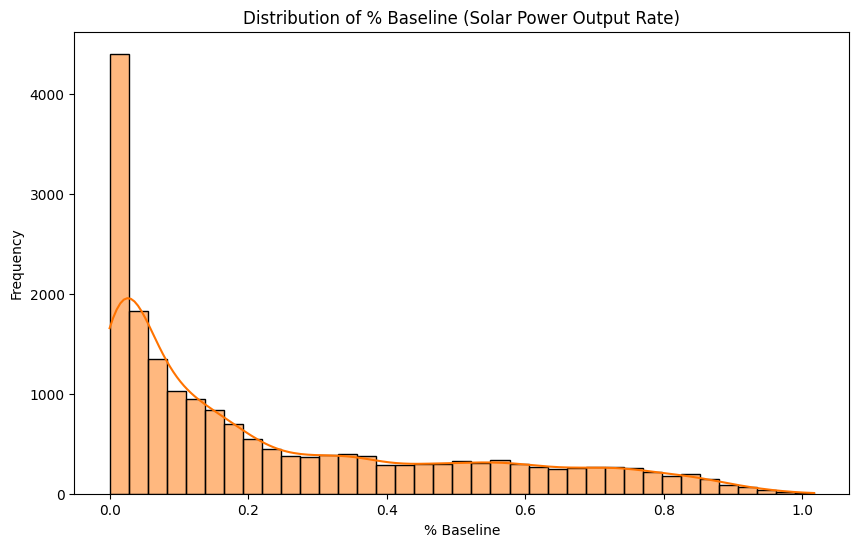

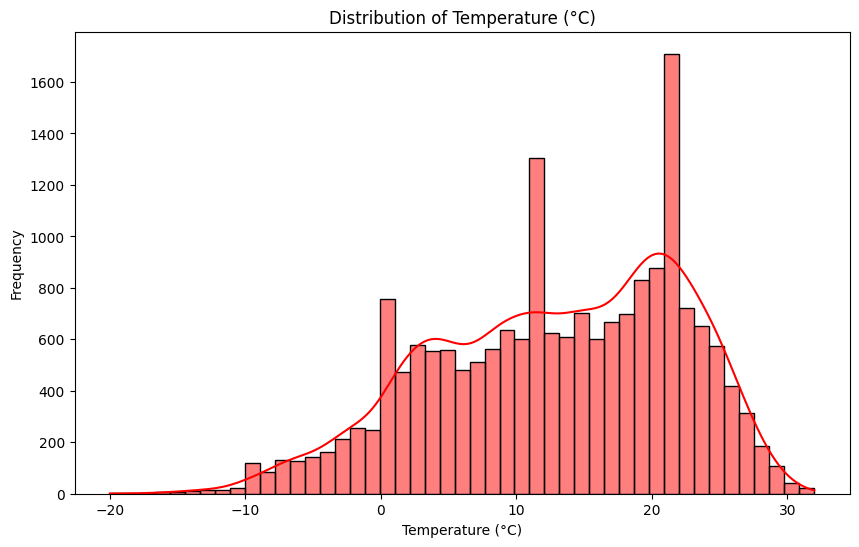

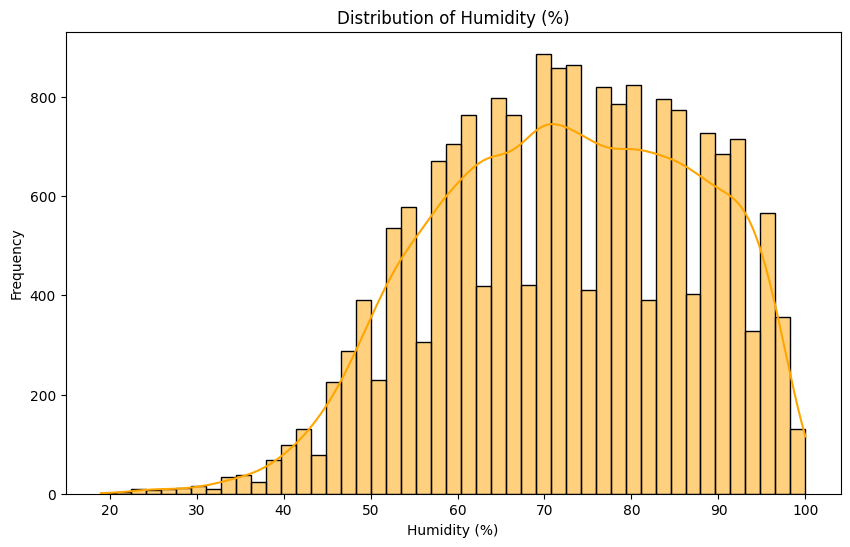

In [18]:
# Data Distribution
# Visualize the distribution of the target variable (% Baseline)
plt.figure(figsize=(10, 6))
sns.histplot(merged_train['% Baseline'], kde=True, color='#FF7300')
plt.title('Distribution of % Baseline (Solar Power Output Rate)')
plt.xlabel('% Baseline')
plt.ylabel('Frequency')
plt.show()

# Explore the distribution of key features (e.g., temperature, humidity)
plt.figure(figsize=(10, 6))
sns.histplot(merged_train['tempC'], kde=True, color='#FF0000')
plt.title('Distribution of Temperature (°C)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(merged_train['humidity'], kde=True, color='#FFA500')
plt.title('Distribution of Humidity (%)')
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')
plt.show()

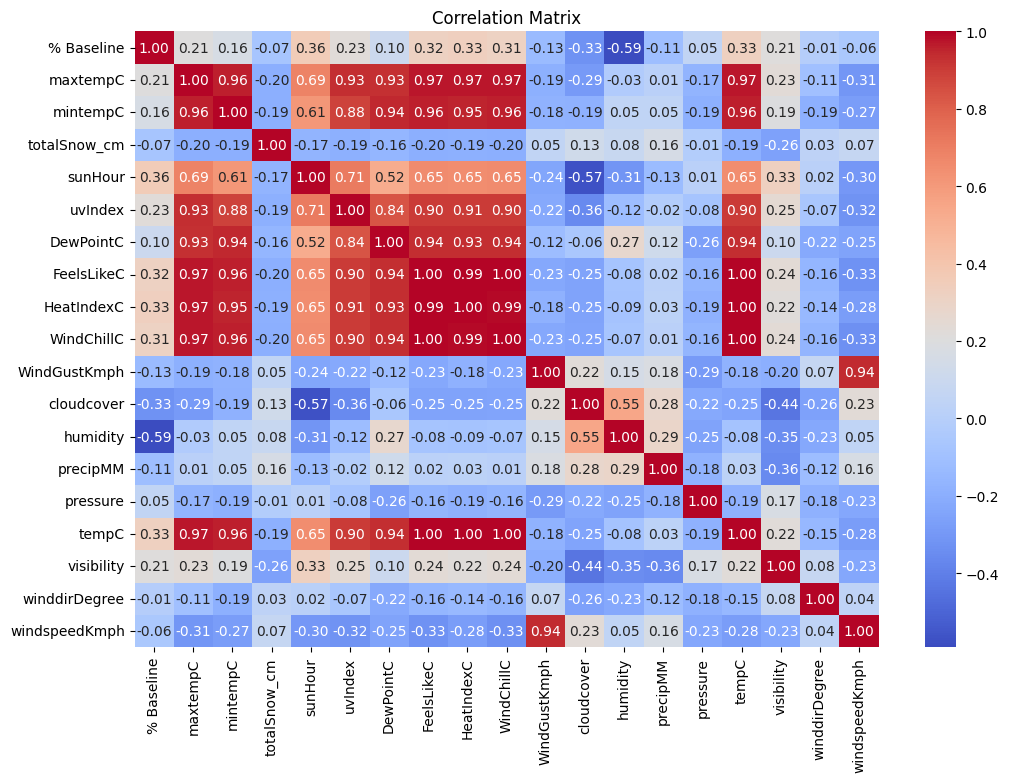

In [19]:
# Correlation Analysis
# Select only numerical columns for correlation analysis
numerical_columns = merged_train.select_dtypes(include=['number'])
correlation_matrix = numerical_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

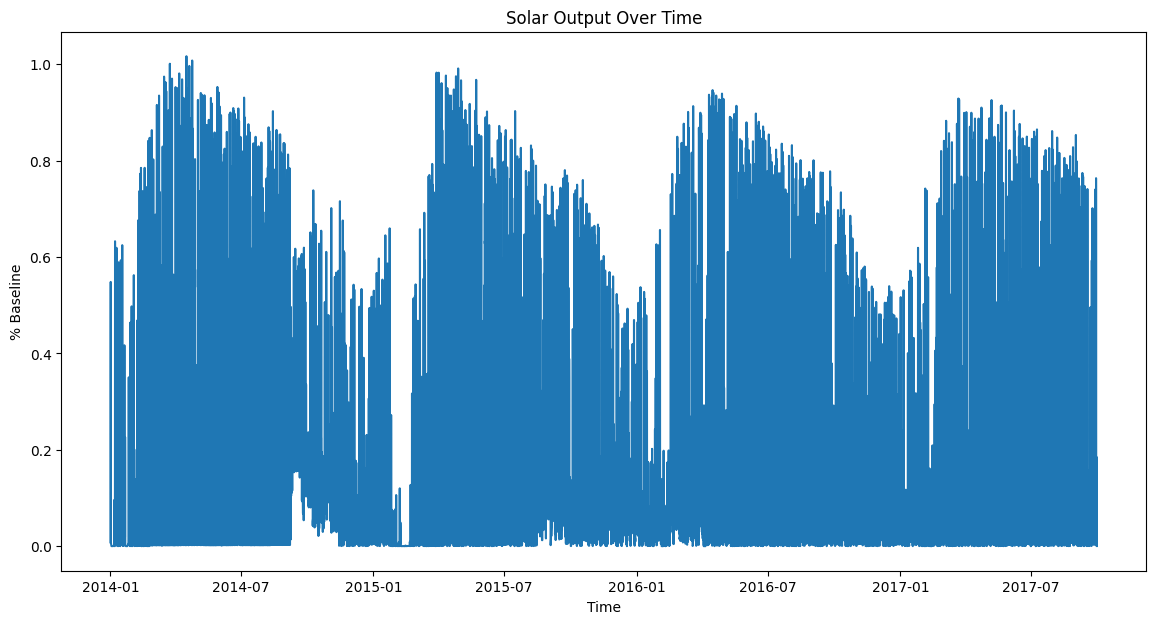

In [20]:
# Time Series Analysis
# Examine trends, seasonality, and patterns in the solar output over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='Timestamp', y='% Baseline', data=merged_train)
plt.title('Solar Output Over Time')
plt.xlabel('Time')
plt.ylabel('% Baseline')
plt.show()

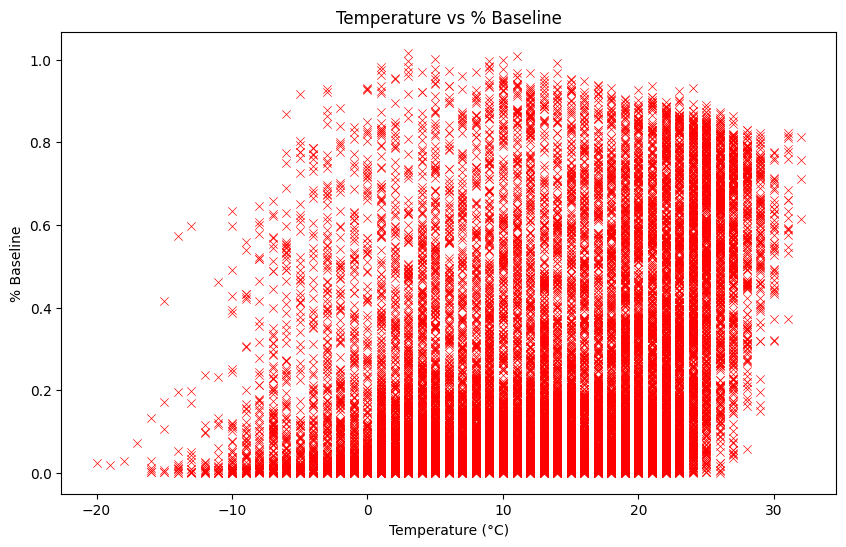

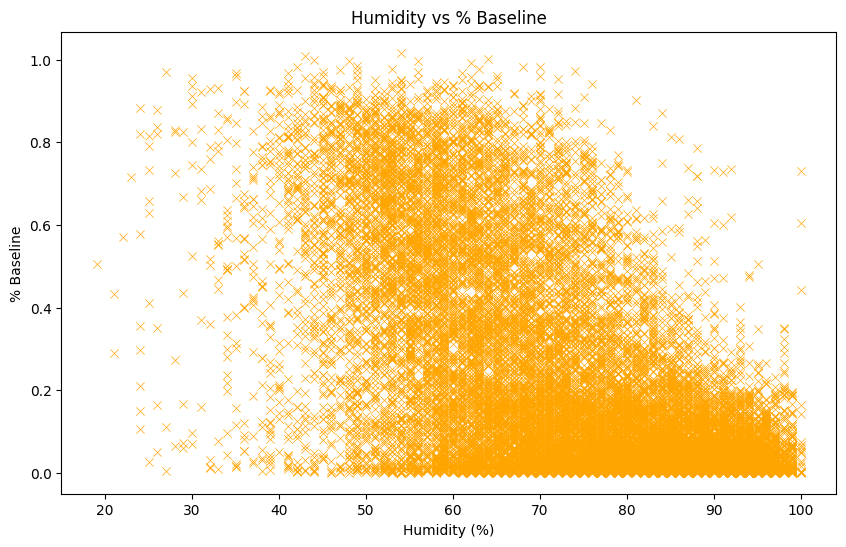

In [21]:
# Relationship Between Features and Target
# Visualize relationships between key features (e.g., temperature, cloud cover) and the target variable
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_train, x='tempC', y='% Baseline', marker='x', color='#FF0000')  # Color code for orange
plt.title('Temperature vs % Baseline')
plt.xlabel('Temperature (°C)')
plt.ylabel('% Baseline')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_train, x='humidity', y='% Baseline', marker='x', color='#FFA500')
plt.title('Humidity vs % Baseline')
plt.xlabel('Humidity (%)')
plt.ylabel('% Baseline')
plt.show()

In [22]:
# Feature Selection
features = ['maxtempC', 'mintempC', 'sunHour', 'uvIndex', 'DewPointC', 'cloudcover', 'humidity', 'precipMM',
            'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']

X = merged_train[features]
y = merged_train['% Baseline']

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model 2: Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Evaluate both models
y_rf_pred = rf_model.predict(X_val)
y_gb_pred = gb_model.predict(X_val)

rf_rmse = np.sqrt(mean_squared_error(y_val, y_rf_pred))
gb_rmse = np.sqrt(mean_squared_error(y_val, y_gb_pred))

print(f"RMSE of Random Forest model: {rf_rmse}")
print(f"RMSE of Gradient Boosting model: {gb_rmse}")

# Choose the best model (Gradient Boosting in this case) for final prediction
best_model = gb_model if gb_rmse < rf_rmse else rf_model
best_model

RMSE of Random Forest model: 0.11750672706846636
RMSE of Gradient Boosting model: 0.15249860194849335


RandomForestRegressor(random_state=42)

In [23]:
# Merge the test data with the weather data using the nearest timestamp
merged_test_data = pd.merge_asof(test_data.sort_values('Timestamp'), weather_data.sort_values('date_time'),
                                 left_on='Timestamp', right_on='date_time')

# Use the same features as in the training data
X_test = merged_test_data[features]

# Make predictions on the test dataset using the best model
test_predictions = best_model.predict(X_test)

# Prepare the submission file
submission = pd.DataFrame({
    'Timestamp': test_data['Timestamp'],
    '% Baseline': test_predictions
})

# Ensure the Timestamp format matches the sample submission
submission['Timestamp'] = submission['Timestamp'].dt.strftime('%b %d, %Y %I%p')

In [25]:
# Save the submission file
submission.to_csv('DAC0023_PejuangDeadline.csv', index=False)

# Download the submission file
files.download('DAC0023_PejuangDeadline.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>